# The JPEG algorithm

In [16]:
# Importing our classes
from jpeg.image import MacroBlock, MyImage
from skimage.io import imshow
import numpy as np

This notebook will present to you the underlying principles of the JPEG compression algorithm. We will be detailing each steps as well as testing the effectiveness of the compression.

## Why we do what we do

An image can be represented by a linear combination of each element of its canonical basis. (Which is represented by a matrix having 1 at the given pixel and 0 elsewhere).
It is difficult to know which information to cut while still retaining good accuracy in the canonical basis.

We thus will be using the DCT, which has the advantage of decomposing the image with a basis where the lower indices correspond to lower frequencies, and the higher frequencies to high frequencies. That way we can cut from the image the frequencies deemed "less important", and compress it.

Before applying the transform, we will be splitting the image into macroblocks of size 8x8.
The advantage of 8x8 blocks is that there is less variation in frequency. Therefore, the compression algorithm will be applied on those 8x8 blocks representing the image.


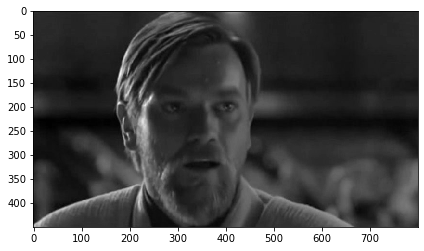

In [48]:
obi = MyImage.from_image("hello_there.jpg").grayscale()
imshow(obi.array)

To be able to split the image in 8x8 blocks, we have to add padding to the images so that its dimensions are multiples of 8.

To avoid JPEG artifacts, and avoid to add high frequencies, we will be padding using the symmetric.

In [49]:
def pad(arr):
    height, width= arr.shape

    height_pad = 8 - height % 8 if height % 8 != 0 else 0
    width_pad = 8 - width % 8 if width % 8 != 0 else 0

    arr = np.pad(arr, [(0, height_pad), (0, width_pad)], mode="symmetric")
    return arr

Shape before padding (450, 800)
Shape after padding (456, 800)


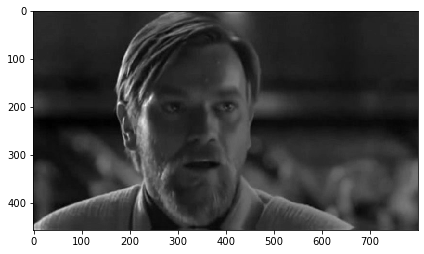

In [50]:
print('Shape before padding', obi.array.shape)
obi_padded = pad(obi.array)
imshow(obi_padded)
print('Shape after padding', obi_padded.shape)

We will now focus on one macroblock, after splitting the image

In [58]:
def split(arr, q, space='RGB'):
    split_height = arr.shape[0] / 8
    split_width = arr.shape[1] / 8
    return (
        np.array(
            [
                [MacroBlock(y, q, space) for y in np.split(x, split_width, axis=1)]
                for x in np.split(arr, split_height)
            ]
        )
    )

In [60]:
macroblocks = split(obi_padded, 50)

One of the macro blocks contains those greyscale values. We see that the are all very close to each other.

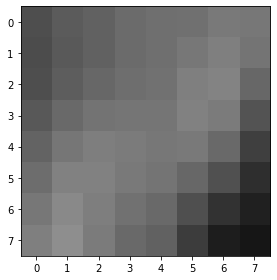

In [91]:
imshow(macroblocks[13, 25].array)

We will first apply the DCT on this block, then use the quantization matrix to retain the relevant values, with the help of the quality factor q.

In fact those operations are all done in the constructor of our macroblock class.

In [101]:
def dct8_line(n):
    return np.fromfunction(lambda i: np.cos((i * 2 * n + n) * np.pi / 16), (8,))

def build_dct8():
    return 0.5 * np.array(
        [
            np.full((8,), 1 / np.sqrt(2)),
            dct8_line(1),
            dct8_line(2),
            dct8_line(3),
            dct8_line(4),
            dct8_line(5),
            dct8_line(6),
            dct8_line(7),
        ]
    )
build_dct8()

array([[ 0.35355339,  0.35355339,  0.35355339,  0.35355339,  0.35355339,
         0.35355339,  0.35355339,  0.35355339],
       [ 0.49039264,  0.41573481,  0.27778512,  0.09754516, -0.09754516,
        -0.27778512, -0.41573481, -0.49039264],
       [ 0.46193977,  0.19134172, -0.19134172, -0.46193977, -0.46193977,
        -0.19134172,  0.19134172,  0.46193977],
       [ 0.41573481, -0.09754516, -0.49039264, -0.27778512,  0.27778512,
         0.49039264,  0.09754516, -0.41573481],
       [ 0.35355339, -0.35355339, -0.35355339,  0.35355339,  0.35355339,
        -0.35355339, -0.35355339,  0.35355339],
       [ 0.27778512, -0.49039264,  0.09754516,  0.41573481, -0.41573481,
        -0.09754516,  0.49039264, -0.27778512],
       [ 0.19134172, -0.46193977,  0.46193977, -0.19134172, -0.19134172,
         0.46193977, -0.46193977,  0.19134172],
       [ 0.09754516, -0.27778512,  0.41573481, -0.49039264,  0.49039264,
        -0.41573481,  0.27778512, -0.09754516]])

This code is used to build the dct8 matrix used to perform the dct following this formula :

$$D_N(j,k) = \alpha(j) \cos\left(\frac{\pi(2k + 1)j}{2N}\right) $$
where $\alpha(j)=$
$$
\begin{cases}
    \sqrt{\frac1N} \text{ if $j=0$} \\
    \sqrt{\frac2N} \text{ otherwise}
\end{cases}

 $$

The operation is then easily done.
$$\mathcal{I}_D = D_8\mathcal{I}D_8^\intercal $$

We also substract 128 from all values because the DC coefficient is often around this value, and this way it can sometimes be taken to 0.

array([[-2.00250000e+02,  6.00093859e+01, -7.77977056e+01,
         1.04824357e+01, -3.55000000e+01, -9.05834356e-01,
        -1.40474018e+01,  5.44618067e-01],
       [ 3.66490451e+01, -1.60737306e+02,  2.55403444e+01,
        -4.40711144e+00, -9.65111773e-01,  1.74756126e+01,
        -3.76967947e-01, -1.33478341e+00],
       [-4.00194650e+01,  3.47248799e+01,  2.00030483e+01,
        -1.47102567e+01,  2.44624103e+01, -1.72199973e+01,
        -3.53553391e-01,  4.46400050e-01],
       [ 1.16710770e+01,  4.49863973e+00, -7.71568885e+00,
        -1.24948304e+00, -5.61542271e-01, -9.19032884e-03,
        -5.64852231e-02,  4.54446556e-01],
       [ 1.50990331e-14,  7.24833997e+00, -2.30969883e-01,
        -2.17925523e-02,  2.50000000e-01, -1.28419856e-01,
         9.56708581e-02,  2.63820123e-01],
       [-4.49127884e-02,  1.74233100e-01, -1.01883806e-01,
         4.47916452e-01, -5.25546771e-01, -4.51004076e-01,
         7.52311642e-03, -2.11515381e-01],
       [ 7.01241267e-02, -6.536933

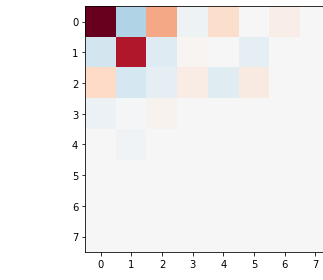

In [99]:
def spectrum(mb):
    return (
        MacroBlock.d8 @ (np.array(mb.array, dtype="int") - 128) @ MacroBlock.d8.T
    )
dct_obi_macro = spectrum(macroblocks[13, 25])
imshow(dct_obi_macro)
dct_obi_macro

After having applied the DCT we need to round the block values, so that we only keep the significant ones.
This is also where the quality factor will come into play

In [ ]:
def _quantize(spectrum, q, space):
    alpha = 5000 / q if q < 50 else 200 - 2 * q
    qmat = MacroBlock.quv_mat if space == "YUV" else MacroBlock.q_mat
    return np.round(spectrum / np.round((qmat * alpha + 50) / 100))

In [90]:
macroblocks[13, 25].coefs

array([-13.,   3.,   5.,  -8., -13.,  -3.,   1.,   2.,   2.,   1.,  -1.,
        -0.,   1.,   0.,   0.,  -0.,   0.,  -0.,  -1.,  -0.,  -0.,  -0.,
         0.,   1.])